# Analysis of Shuffling Batches
Shuffling batches refers to the act of shuffling the training data each epoch and producing different batches, as opposed to only shuffling the data once at the beginning and producing an identical set of batches each epoch.

First thing to point out is that using the ReLU activation in regression can cause the model loss blow up sometimes. The analysis is performed with these large values left in the data. Normally I would not consider models would for comparison, but I wish to measure what performance from the first $n$ trained models, rather than the first $n$ successful models. 

Also due to the different loss metrics being used in regression and classification (RMSE & negative log loss) they are hard to compare, e.g. at what point is a RMSE measurement equivalent to a log loss measurement?. For this reason the comparisons containing both learning tasks should be considered carefully.

For hypothesis testing Welch's t-test is used, and a p-value less than or equal to .001 is used as the threshold for deciding whether a difference is statistically significant.

## Notes
This analysis may not be valid as appears that the data is not normally distributed and is heavily skewed, ruling out the use of a t-test. Furthermore, it is said that you cannot use the t-test on multiple groups with multiple independent variables.

## Summary
Shuffling batches seems to benefit generalisation ability the most, and is at times harmful to test performance. 

Some guidelines derived from the analyses:
- Shuffling batches improves validation accuracy.
- Shuffling batches is not beneficial when the goal is to evaluate the ability to learn the data and generalisation is not expected (e.g. for toy datasets such as XOR).
- Shuffling batches is always recommended when working on classification tasks. 

A general piece of advice: 
- Do to not use ReLU on regression tasks unless you are willing to spend more time than usual tuning hyperparameters.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
os.getcwd()

'/home/anthony/420/notebooks'

In [3]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 168 entries, activation_func to val_loss_39
dtypes: bool(1), float64(163), int64(1), object(3)
memory usage: 5.8+ MB


In [4]:
df.describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_loss_00,train_loss_01,train_loss_02,train_loss_03,train_loss_04,train_loss_05,...,val_loss_30,val_loss_31,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39
count,4536.000000,4536.000000,4536.000000,4536.000000,4.469000e+03,4.465000e+03,4.474000e+03,4.460000e+03,4.468000e+03,4.480000e+03,...,1.291000e+03,1.291000e+03,1.291000e+03,1.293000e+03,1.284000e+03,1.289000e+03,1.286000e+03,1.287000e+03,1.285000e+03,1.288000e+03
mean,3.238095,0.036667,0.037000,0.466667,6.139973e+148,1.178551e+143,2.240893e+146,1.080856e+143,5.007608e+146,1.060628e+132,...,3.490164e+139,1.192571e+140,6.523714e+144,3.004334e+88,5.270054e+87,2.447946e+133,2.201866e+139,7.127668e+127,1.836580e+128,4.176261e+140
std,7.432443,0.044974,0.044704,0.368219,4.104608e+150,7.788403e+144,1.498695e+148,7.218305e+144,3.347240e+148,7.099082e+133,...,1.254033e+141,4.284966e+141,2.344002e+146,1.079347e+90,1.846660e+89,8.788773e+134,7.896076e+140,2.557036e+129,6.583569e+129,1.498806e+142
min,-1.000000,0.000000,0.001000,0.000000,3.878009e-12,1.887379e-15,6.075696e-14,1.249001e-15,2.439715e-14,7.771561e-16,...,1.205098e-02,4.532566e-03,4.032520e-03,8.639882e-07,2.478734e-02,9.347693e-04,1.913314e-02,1.281576e-02,3.864593e-03,1.995955e-02
25%,-1.000000,0.000000,0.001000,0.000000,2.304792e-01,2.317160e-01,2.297833e-01,2.342466e-01,2.307808e-01,2.303364e-01,...,1.340462e-01,1.338613e-01,1.409296e-01,1.371336e-01,1.328476e-01,1.330931e-01,1.354859e-01,1.379978e-01,1.337317e-01,1.374174e-01
50%,1.000000,0.010000,0.010000,0.500000,5.006268e-01,5.005960e-01,5.009687e-01,5.008767e-01,5.006290e-01,5.009712e-01,...,2.280760e-01,2.075429e-01,2.246615e-01,2.367095e-01,2.146115e-01,2.205804e-01,2.219849e-01,2.380792e-01,2.077034e-01,2.332943e-01
75%,2.000000,0.100000,0.100000,0.900000,6.950951e-01,6.948118e-01,6.947904e-01,6.948717e-01,6.953892e-01,6.954834e-01,...,3.588411e-01,3.450229e-01,3.522622e-01,3.709971e-01,3.579938e-01,3.465480e-01,3.506236e-01,3.654653e-01,3.506442e-01,3.557505e-01
max,32.000000,0.100000,0.100000,0.900000,2.743954e+152,5.203949e+146,1.002447e+150,4.820618e+146,2.237399e+150,4.751615e+135,...,4.505802e+142,1.539609e+143,8.422115e+147,3.881150e+91,6.615518e+90,3.155402e+136,2.831599e+142,9.173309e+130,2.360005e+131,5.379024e+143


In [5]:
df.describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_loss_00,train_loss_01,train_loss_02,train_loss_03,train_loss_04,train_loss_05,...,val_loss_30,val_loss_31,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39
count,4536.000000,4536.000000,4536.000000,4536.000000,4.469000e+03,4.465000e+03,4.474000e+03,4.460000e+03,4.468000e+03,4.480000e+03,...,1.291000e+03,1.291000e+03,1.291000e+03,1.293000e+03,1.284000e+03,1.289000e+03,1.286000e+03,1.287000e+03,1.285000e+03,1.288000e+03
mean,3.238095,0.036667,0.037000,0.466667,6.139973e+148,1.178551e+143,2.240893e+146,1.080856e+143,5.007608e+146,1.060628e+132,...,3.490164e+139,1.192571e+140,6.523714e+144,3.004334e+88,5.270054e+87,2.447946e+133,2.201866e+139,7.127668e+127,1.836580e+128,4.176261e+140
std,7.432443,0.044974,0.044704,0.368219,4.104608e+150,7.788403e+144,1.498695e+148,7.218305e+144,3.347240e+148,7.099082e+133,...,1.254033e+141,4.284966e+141,2.344002e+146,1.079347e+90,1.846660e+89,8.788773e+134,7.896076e+140,2.557036e+129,6.583569e+129,1.498806e+142
min,-1.000000,0.000000,0.001000,0.000000,3.878009e-12,1.887379e-15,6.075696e-14,1.249001e-15,2.439715e-14,7.771561e-16,...,1.205098e-02,4.532566e-03,4.032520e-03,8.639882e-07,2.478734e-02,9.347693e-04,1.913314e-02,1.281576e-02,3.864593e-03,1.995955e-02
25%,-1.000000,0.000000,0.001000,0.000000,2.304792e-01,2.317160e-01,2.297833e-01,2.342466e-01,2.307808e-01,2.303364e-01,...,1.340462e-01,1.338613e-01,1.409296e-01,1.371336e-01,1.328476e-01,1.330931e-01,1.354859e-01,1.379978e-01,1.337317e-01,1.374174e-01
50%,1.000000,0.010000,0.010000,0.500000,5.006268e-01,5.005960e-01,5.009687e-01,5.008767e-01,5.006290e-01,5.009712e-01,...,2.280760e-01,2.075429e-01,2.246615e-01,2.367095e-01,2.146115e-01,2.205804e-01,2.219849e-01,2.380792e-01,2.077034e-01,2.332943e-01
75%,2.000000,0.100000,0.100000,0.900000,6.950951e-01,6.948118e-01,6.947904e-01,6.948717e-01,6.953892e-01,6.954834e-01,...,3.588411e-01,3.450229e-01,3.522622e-01,3.709971e-01,3.579938e-01,3.465480e-01,3.506236e-01,3.654653e-01,3.506442e-01,3.557505e-01
max,32.000000,0.100000,0.100000,0.900000,2.743954e+152,5.203949e+146,1.002447e+150,4.820618e+146,2.237399e+150,4.751615e+135,...,4.505802e+142,1.539609e+143,8.422115e+147,3.881150e+91,6.615518e+90,3.155402e+136,2.831599e+142,9.173309e+130,2.360005e+131,5.379024e+143


In [6]:
df.head()

,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,train_loss_00,train_loss_01,...,val_loss_30,val_loss_31,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39
run_id,,,,,,,,,,,,,,,,,,,,,
ce2406bc88ceda4e2fde96bf96fdd2d5,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,True,5.166794e-01,5.365412e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745da0d20037327f586babfb38077b62,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,False,4.087733e-01,1.385021e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aeeec51b4e4d9c885bd53d0de5c46b14,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,True,3.247473e-01,4.423432e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a99a2a1ecd0377d4d4d5c47d3015771b,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,False,6.579213e-01,3.202256e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a523da2d87ca23feb5411114cf717710,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.0,True,5.498153e+38,1.364288e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
metrics = ['train_loss', 'train_scores', 'val_loss', 'val_scores']

# Shuffling Batches in Regression Tasks
It is difficult to comment on whether or not there is any improvement in loss since the results are not statistically significant. However, there is statistically significant evidence that shuffling batches negatively influences training scores, while also improving generalisation ability (validation scores).

In [8]:
def print_stats(dataframe, name='a'):
    a = dataframe
    print('Summary for %s:' % name)
    print('n: %d' % len(a.dropna()))
    # Do aggregate functions (e.g. mean()) twice to get column-wise and then datafram-wise measures.
    print('min: %.4e - max: %.4e' % (a.min().min(), a.max().max()))
    print('μ ± 2σ: %.4e ± %.4e' % (a.mean().mean(), 2 * a.std().std()))
    print('Quartiles - 1st: %.4e - 2nd: %.4e - 3rd: %.4e' % (a.quantile(0.25).quantile(0.25),
                                                            a.quantile(0.5).quantile(0.5),
                                                            a.quantile(0.75).quantile(0.75)))
     
        
def format_p_value(p_value):
    return str(p_value % 1)[1:5] if p_value > 0.001 else '<.001'
        
def stat_test(masks, test_name, alpha=0.001):    
    assert len(masks) == 2

    print('*' * 80)
    print(test_name)
    print('*' * 80)
    
    for metric in metrics:
        print('#'  * len(metric))
        print(metric)
        print('#'  * len(metric))
    
        a = df[masks[0]].filter(regex=metric + '_\d{2}')
        b = df[masks[1]].filter(regex=metric + '_\d{2}')
    
        print_stats(a, name='a')
        print()

        print_stats(b, name='b')
        print()
        
        print('Welch t-test:')
        t, p = stats.ttest_ind(a.values.ravel(), b.values.ravel(), equal_var=False, nan_policy='omit')
        print('t: %.4f - p: %s' % (t, format_p_value(p)))

In [9]:
shuffles_batch = df['shuffle_batches'] == True
no_shuffling = df['shuffle_batches'] == False
using_regression = df['clf_type'] == 'MLPRegressor'

stat_test(masks=(shuffles_batch & using_regression, no_shuffling & using_regression), 
          test_name='Regression - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Regression - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 1077
min: 7.2164e-16 - max: 2.7440e+152
μ ± 2σ: 6.5877e+147 ± 2.5883e+150
Quartiles - 1st: 1.7842e-01 - 2nd: 3.1288e-01 - 3rd: 5.0199e-01

Summary for b:
n: 1073
min: 1.1102e-16 - max: 2.9061e+153
μ ± 2σ: 1.0371e+149 ± 3.0517e+151
Quartiles - 1st: 1.7462e-01 - 2nd: 3.0158e-01 - 3rd: 5.0127e-01

Welch t-test:
t: -1.3314 - p: .410
############
train_scores
############
Summary for a:
n: 887
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.4695e-01 ± 9.6442e-03
Quartiles - 1st: 4.4577e-02 - 2nd: 6.6760e-01 - 3rd: 9.4845e-01

Summary for b:
n: 791
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.9063e-01 ± 1.6218e-02
Quartiles - 1st: 2.3345e-01 - 2nd: 6.7216e-01 - 3rd: 9.4939e-01

Welch t-test:
t: -14.6843 - p: <.001
########
val_l

/home/anthony/miniconda3/envs/cosc420/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:1068: RuntimeWarning: overflow encountered in double_scalars
  df = (vn1 + vn2)**2 / (vn1**2 / (n1 - 1) + vn2**2 / (n2 - 1))


Quartiles - 1st: 1.4416e-01 - 2nd: 1.9098e-01 - 3rd: 3.1101e-01

Summary for b:
n: 305
min: 6.3192e-02 - max: 4.4136e+149
μ ± 2σ: 3.4163e+145 ± 7.7658e+147
Quartiles - 1st: 1.5573e-01 - 2nd: 2.7896e-01 - 3rd: 3.3380e-01

Welch t-test:
t: -0.9721 - p: .509
##########
val_scores
##########
Summary for a:
n: 302
min: -4.6464e-01 - max: 9.9346e-01
μ ± 2σ: 7.9645e-01 ± 2.4961e-02
Quartiles - 1st: 7.0430e-01 - 2nd: 8.9939e-01 - 3rd: 9.4279e-01

Summary for b:
n: 306
min: -5.0256e-01 - max: 9.9011e-01
μ ± 2σ: 7.2051e-01 ± 1.7680e-02
Quartiles - 1st: 6.7611e-01 - 2nd: 7.7064e-01 - 3rd: 9.3221e-01

Welch t-test:
t: 24.9651 - p: <.001


In [10]:
using_relu = df['activation_func'] == 'LeakyReLU'

stat_test(masks=(shuffles_batch & using_regression & using_relu, no_shuffling & using_regression & using_relu), 
          test_name='Regression using ReLU Activation - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Regression using ReLU Activation - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 517
min: 2.6007e-14 - max: 2.7440e+152
μ ± 2σ: 1.3287e+148 ± 3.6768e+150
Quartiles - 1st: 2.0113e-01 - 2nd: 3.2423e-01 - 3rd: 5.0204e-01

Summary for b:
n: 519
min: 1.1102e-16 - max: 2.9061e+153
μ ± 2σ: 2.0791e+149 ± 4.3211e+151
Quartiles - 1st: 1.8675e-01 - 2nd: 3.1244e-01 - 3rd: 5.0109e-01

Welch t-test:
t: -1.3311 - p: .410
############
train_scores
############
Summary for a:
n: 427
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.4672e-01 ± 1.3455e-02
Quartiles - 1st: 1.4938e-01 - 2nd: 6.5393e-01 - 3rd: 9.4019e-01

Summary for b:
n: 386
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.7362e-01 ± 2.6014e-02
Quartiles - 1st: 2.4996e-01 - 2nd: 6.5455e-01 - 3rd: 9.3857e-01

Welch t-test:
t: -6.5395 - p: <

In [11]:
using_sigmoid = df['activation_func'] == 'Sigmoid'

stat_test(masks=(shuffles_batch & using_regression & using_sigmoid, 
                 no_shuffling & using_regression & using_sigmoid), 
          test_name='Regression using Sigmoid Activation - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Regression using Sigmoid Activation - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 560
min: 7.2164e-16 - max: 2.1414e+00
μ ± 2σ: 3.1824e-01 ± 8.9017e-03
Quartiles - 1st: 1.4724e-01 - 2nd: 2.9819e-01 - 3rd: 5.0208e-01

Summary for b:
n: 554
min: 4.4409e-16 - max: 1.9929e+00
μ ± 2σ: 3.1560e-01 ± 7.6206e-03
Quartiles - 1st: 1.5110e-01 - 2nd: 2.8748e-01 - 3rd: 5.0145e-01

Welch t-test:
t: 1.5599 - p: .118
############
train_scores
############
Summary for a:
n: 460
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.4718e-01 ± 1.3379e-02
Quartiles - 1st: 3.0323e-03 - 2nd: 6.8760e-01 - 3rd: 9.5232e-01

Summary for b:
n: 405
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 6.0757e-01 ± 1.2087e-02
Quartiles - 1st: 1.5360e-01 - 2nd: 7.0083e-01 - 3rd: 9.5554e-01

Welch t-test:
t: -14.0702 - p: <.00

# Aside: Using ReLU Activation in Regression Tasks
One thing to note is the drastically difference between the max loss values between using ReLU and using Sigmoid activations. This is possibly due the learning rate having a different effect the different activation functions.

It is hard to comment of the effect of using ReLU on loss due to the results not being statistically significant. However, there is a statistically significant negative relationship between using ReLU and training scores. This effect is even more pronounced in the validation scores.

In [12]:
stat_test(masks=(using_regression & ~using_sigmoid, 
                 using_regression & using_sigmoid), 
          test_name='Regression - ReLU vs Sigmoid Activation:')

********************************************************************************
Regression - ReLU vs Sigmoid Activation:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 1036
min: 1.1102e-16 - max: 2.9061e+153
μ ± 2σ: 1.1083e+149 ± 3.0597e+151
Quartiles - 1st: 1.9589e-01 - 2nd: 3.1738e-01 - 3rd: 5.0149e-01

Summary for b:
n: 1114
min: 4.4409e-16 - max: 2.1414e+00
μ ± 2σ: 3.1692e-01 ± 6.0567e-03
Quartiles - 1st: 1.5064e-01 - 2nd: 2.9160e-01 - 3rd: 5.0164e-01

Welch t-test:
t: 1.5112 - p: .372
############
train_scores
############
Summary for a:
n: 813
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.5943e-01 ± 1.4665e-02
Quartiles - 1st: 1.9740e-01 - 2nd: 6.5443e-01 - 3rd: 9.3910e-01

Summary for b:
n: 865
min: -1.0000e+00 - max: 1.0000e+00
μ ± 2σ: 5.7553e-01 ± 8.9436e-03
Quartiles - 1st: 3.3339e-02 - 2nd: 6.9398e-01 - 3rd: 9.5312e-01

Welch t-test:
t: -5.3971 - p: <.001
########
val_loss
########
Summary f

# Shuffling Batches in Classification Tasks

With the exception of the training metrics when using the sigmoid activation, we see statistically significant results. There is a much clearer trend when it comes to classification, we see consistent improvement in all metrics, with more marked improvement in validation performance.

In [13]:
using_classification = df['clf_type'] == 'MLPClassifier'

stat_test(masks=(shuffles_batch & using_classification, no_shuffling & using_classification), 
          test_name='Classification - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Classification - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 964
min: 6.6351e-03 - max: 5.1808e+01
μ ± 2σ: 1.4443e+00 ± 6.5767e-01
Quartiles - 1st: 4.6527e-01 - 2nd: 6.9411e-01 - 3rd: 8.5949e-01

Summary for b:
n: 969
min: 8.1027e-03 - max: 4.4671e+01
μ ± 2σ: 1.5245e+00 ± 7.2667e-01
Quartiles - 1st: 4.5403e-01 - 2nd: 6.9411e-01 - 3rd: 9.1865e-01

Welch t-test:
t: -3.7916 - p: <.001
############
train_scores
############
Summary for a:
n: 964
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 7.2481e-01 ± 6.7188e-03
Quartiles - 1st: 5.0000e-01 - 2nd: 7.5404e-01 - 3rd: 9.7656e-01

Summary for b:
n: 972
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 7.1432e-01 ± 7.1212e-03
Quartiles - 1st: 5.0000e-01 - 2nd: 7.5000e-01 - 3rd: 9.7539e-01

Welch t-test:
t: 5.7401 - p: <.001
########
val_loss
###

In [14]:
stat_test(masks=(shuffles_batch & using_classification & using_relu, 
                 no_shuffling & using_classification & using_relu), 
          test_name='Classification using ReLU Activation - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Classification using ReLU Activation - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 480
min: 6.6351e-03 - max: 5.1808e+01
μ ± 2σ: 1.7015e+00 ± 9.8321e-01
Quartiles - 1st: 4.3392e-01 - 2nd: 6.9319e-01 - 3rd: 8.1937e-01

Summary for b:
n: 483
min: 8.1027e-03 - max: 4.4671e+01
μ ± 2σ: 1.8547e+00 ± 1.0712e+00
Quartiles - 1st: 4.4635e-01 - 2nd: 6.9346e-01 - 3rd: 9.0703e-01

Welch t-test:
t: -3.8645 - p: <.001
############
train_scores
############
Summary for a:
n: 480
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 7.5303e-01 ± 1.0009e-02
Quartiles - 1st: 5.0000e-01 - 2nd: 8.7500e-01 - 3rd: 9.8333e-01

Summary for b:
n: 486
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 7.3373e-01 ± 1.0651e-02
Quartiles - 1st: 5.0000e-01 - 2nd: 8.4531e-01 - 3rd: 9.8346e-01

Welch t-test:
t: 7.7434 - p: <.001

In [15]:
stat_test(masks=(shuffles_batch & using_classification & using_sigmoid, 
                 no_shuffling & using_classification & using_sigmoid), 
          test_name='Classification using Sigmoid Activation - Shuffling Batches vs. Not Shuffling Batches:')

********************************************************************************
Classification using Sigmoid Activation - Shuffling Batches vs. Not Shuffling Batches:
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 484
min: 1.3374e-02 - max: 9.6380e+00
μ ± 2σ: 1.1862e+00 ± 8.1926e-02
Quartiles - 1st: 4.9731e-01 - 2nd: 6.9466e-01 - 3rd: 9.4391e-01

Summary for b:
n: 486
min: 9.9160e-03 - max: 9.0202e+00
μ ± 2σ: 1.1937e+00 ± 1.0534e-01
Quartiles - 1st: 4.5220e-01 - 2nd: 6.9446e-01 - 3rd: 9.6443e-01

Welch t-test:
t: -0.5336 - p: .593
############
train_scores
############
Summary for a:
n: 484
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 6.9651e-01 ± 1.0900e-02
Quartiles - 1st: 5.0000e-01 - 2nd: 7.4727e-01 - 3rd: 9.7500e-01

Summary for b:
n: 486
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 6.9483e-01 ± 9.8338e-03
Quartiles - 1st: 5.0000e-01 - 2nd: 7.3359e-01 - 3rd: 9.7500e-01

Welch t-test:
t: 0.6309 - p: .52

# Plots

In [16]:
shuffles_batches = df['shuffle_batches'] == True
classification = df['clf_type'] == 'MLPClassifier'
iris = df['dataset'] == 'iris'
relu = df['activation_func'] == 'LeakyReLU'

## Plots to support the claim 'Shuffling batches improves validation accuracy'.

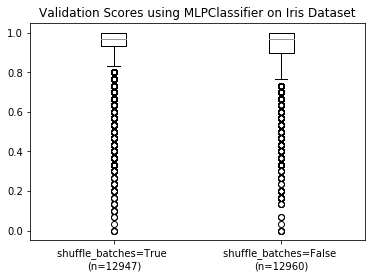

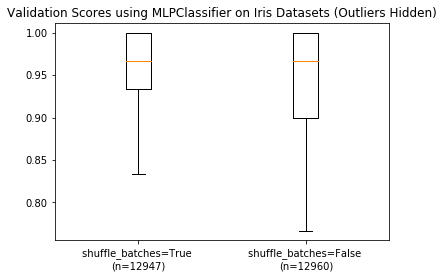

In [17]:
a = df[shuffles_batches & classification].filter(regex='val_scores_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~shuffles_batches & classification].filter(regex='val_scores_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Validation Scores using MLPClassifier on Iris Dataset')
plt.show()

plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Validation Scores using MLPClassifier on Iris Datasets (Outliers Hidden)')
plt.show()

## Plots supporting the claim 'Shuffling batches is always recommended when working on classification tasks'.

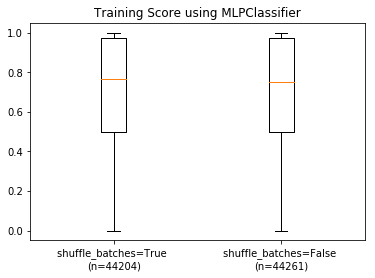

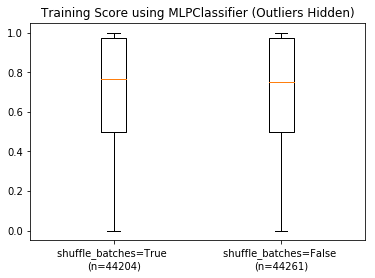

In [18]:
a = df[shuffles_batches & classification].filter(regex='train_scores_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~shuffles_batches & classification].filter(regex='train_scores_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Score using MLPClassifier')
plt.show()

plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Score using MLPClassifier (Outliers Hidden)')
plt.show()

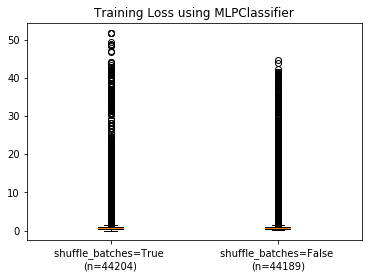

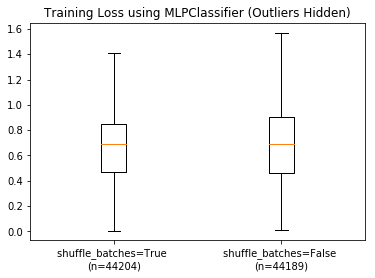

In [19]:
a = df[shuffles_batches & classification].filter(regex='train_loss_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~shuffles_batches & classification].filter(regex='train_loss_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Loss using MLPClassifier')
plt.show()


plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Loss using MLPClassifier (Outliers Hidden)')
plt.show()

## Plots to support the claim 'Shuffling batches is not beneficial when the goal is to evaluate the ability to learn the data and generalisation is not expected.

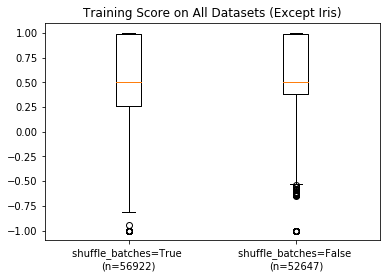

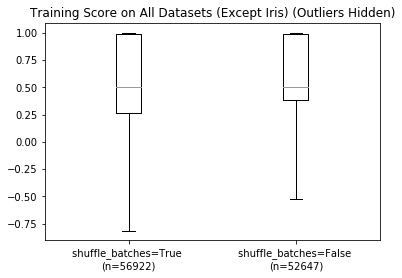

In [20]:
a = df[shuffles_batches & ~iris].filter(regex='train_scores_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~shuffles_batches & ~iris].filter(regex='train_scores_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Score on All Datasets (Except Iris)')
plt.show()

plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Score on All Datasets (Except Iris) (Outliers Hidden)')
plt.show()

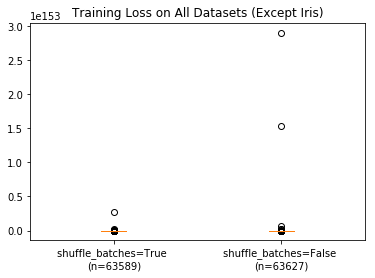

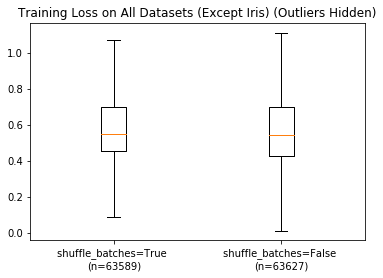

In [21]:
a = df[shuffles_batches & ~iris].filter(regex='train_loss_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~shuffles_batches & ~iris].filter(regex='train_loss_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Loss on All Datasets (Except Iris)')
plt.show()


plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['shuffle_batches=True \n(n=%d)' % len(a), 'shuffle_batches=False \n(n=%d)' % len(b)])
plt.title('Training Loss on All Datasets (Except Iris) (Outliers Hidden)')
plt.show()

## Plots to support the claim 'Do not use ReLU for regresssion'.

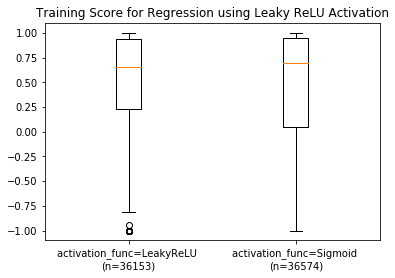

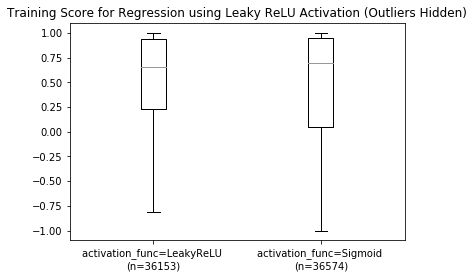

In [22]:
a = df[~classification & relu].filter(regex='train_scores_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~classification & ~relu].filter(regex='train_scores_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['activation_func=LeakyReLU \n(n=%d)' % len(a), 'activation_func=Sigmoid \n(n=%d)' % len(b)])
plt.title('Training Score for Regression using Leaky ReLU Activation')
plt.show()

plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['activation_func=LeakyReLU \n(n=%d)' % len(a), 'activation_func=Sigmoid \n(n=%d)' % len(b)])
plt.title('Training Score for Regression using Leaky ReLU Activation (Outliers Hidden)')
plt.show()

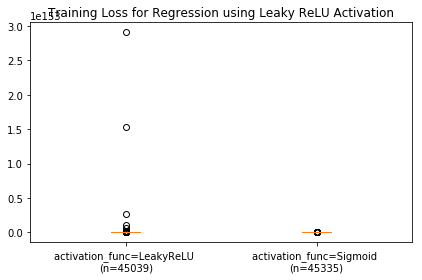

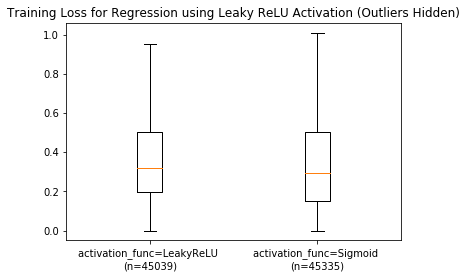

In [23]:
a = df[~classification & relu].filter(regex='train_loss_\d{2}').values
a = a.ravel()
a = a[~np.isnan(a)]

b = df[~classification & ~relu].filter(regex='train_loss_\d{2}').values
b = b.ravel()
b = b[~np.isnan(b)]


plt.boxplot([a, b], showfliers=True)
plt.xticks([1, 2], ['activation_func=LeakyReLU \n(n=%d)' % len(a), 'activation_func=Sigmoid \n(n=%d)' % len(b)])
plt.title('Training Loss for Regression using Leaky ReLU Activation')
plt.tight_layout()
plt.show()

plt.boxplot([a, b], showfliers=False)
plt.xticks([1, 2], ['activation_func=LeakyReLU \n(n=%d)' % len(a), 'activation_func=Sigmoid \n(n=%d)' % len(b)])
plt.title('Training Loss for Regression using Leaky ReLU Activation (Outliers Hidden)')
plt.show()